In [1]:
import itertools

import numpy as np
import jax.numpy as jnp
from jax import random, jit, jacfwd, jacrev, grad, vmap
from jax.numpy.linalg import inv
from jax.nn import tanh, sigmoid, relu
from jax.experimental.ode import odeint

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

np.random.seed(123)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-pfgpkhnn because the default path (/home/jaron/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/home/jaron/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/jaron/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  fro

In [2]:
# generate data from a ground truth ODE model (generalized Lotka-Volterra)

# number of species
n_s = 3 

# growth rates
r = np.random.uniform(.3, .5, n_s)

# interaction matrix
A = np.random.uniform(-.6, .4, size=[n_s, n_s])
for i in range(n_s):
    # self interaction is negative
    A[i, i] = -1.
    
# model parameters will be the latent variables to estimate later
z_true = jnp.append(r, A.flatten())

# function to reshape latent variables 
def reshape_z(z):
    r = z[:n_s]
    A = jnp.reshape(z[n_s:], [n_s, n_s])
    return r, A
    
# generalized Lotka Volterra model (gLV)
def gLV_gt(x, t, z):
    r, A = reshape_z(z)
    return x*(r + jnp.einsum('ij,j->i', A, x)) * (1. - x)

# full factorial  
x0s = [.1*np.reshape(np.array(i), (1, n_s)) for i in itertools.product([0, 1], repeat = n_s)][1:]
# more random communities
for i in range(10):
    x0s.append(np.atleast_2d(np.random.uniform(0, .2, n_s)))
x0s = np.array(np.concatenate(x0s), float)
    
# number of measurement times
m = 3

# time frame
t_span = jnp.linspace(0, 24, m)

# measurement noise (s = standard deviation and beta = precision)
s = 0.01
beta = (1./s)**2

# integrate gLV and add noise to generate simulated data
X = []
for x0 in x0s:
    # integrate ODE
    x = odeint(gLV_gt, jnp.array(x0), t_span, z_true)
    
    # add noise after initial condition of inoculated species
    x = x.at[1:].set(x[1:] + s*np.random.randn(m-1, n_s))
    x = jnp.einsum('tk,k->tk', x, np.array(x[0]>0, int))

    # append to X
    X.append(x)
    
# stack X as an array 
X = np.stack(X)

# # integrate gLV and add noise to generate simulated data
# X = []
# for x0 in x0s:
#     # integrate ODE
#     x = odeint(gLV_gt, jnp.array(x0), t_span, z_true)
    
#     # add noise after initial condition of inoculated species
#     x = x.at[1:].set(x[1:] + s*np.random.randn(m-1, n_s))
#     x = jnp.einsum('tk,k->tk', x, np.array(x[0]>0, int))
    
#     # append to X
#     for xt in x[1:]:
#         X.append(np.stack((x[0], xt)))
    
# # stack X as an array 
# X = np.stack(X)

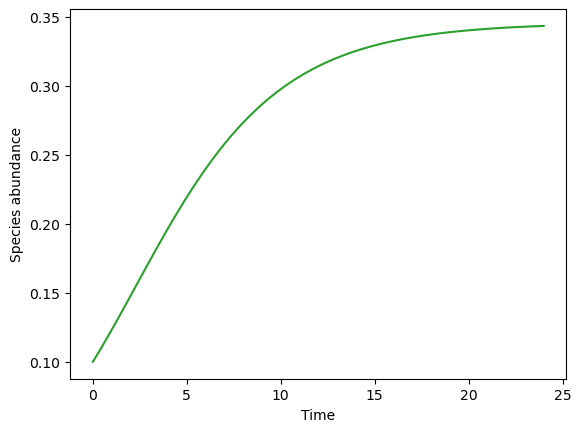

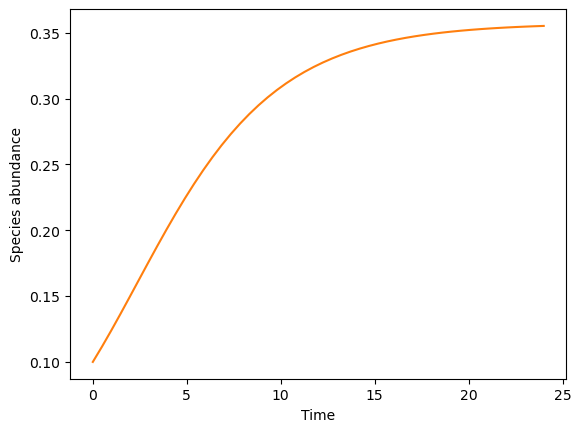

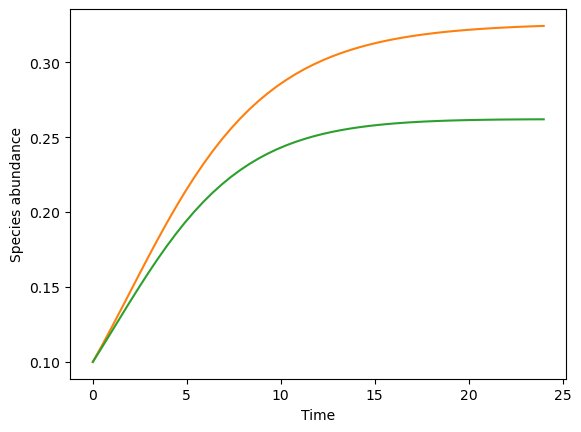

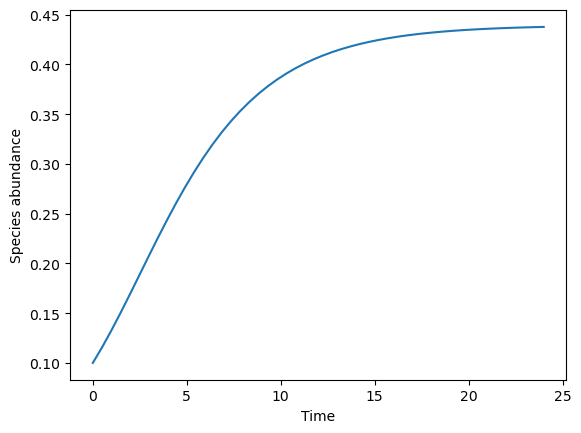

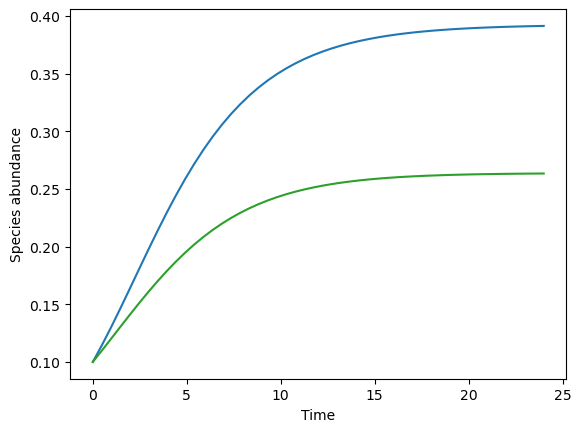

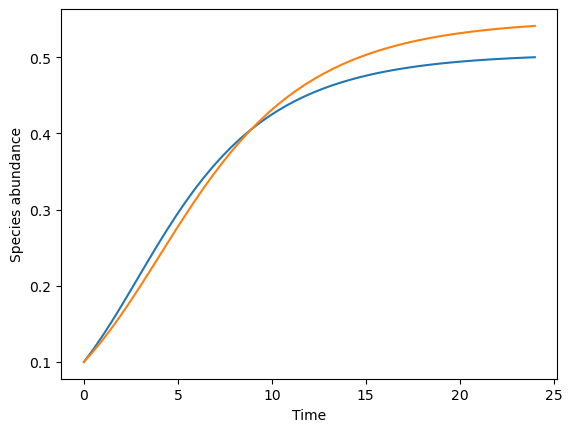

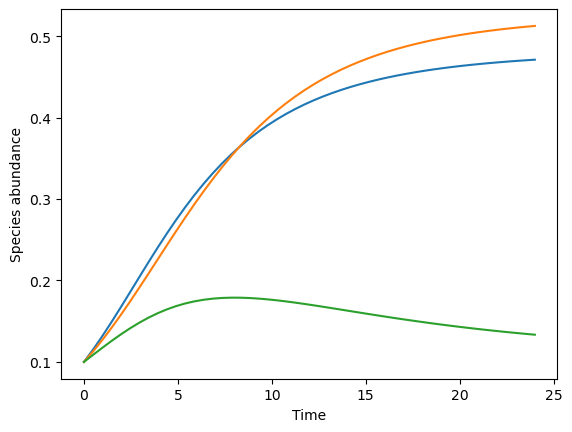

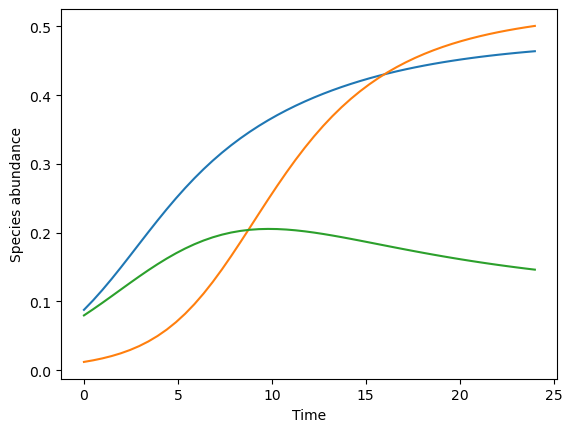

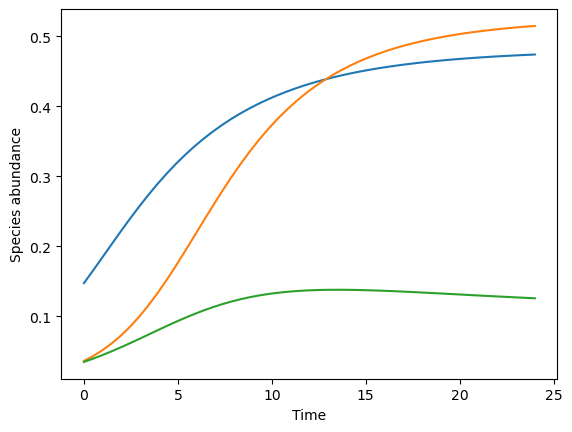

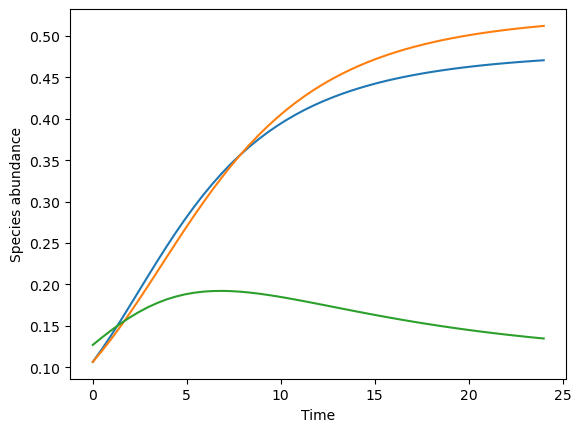

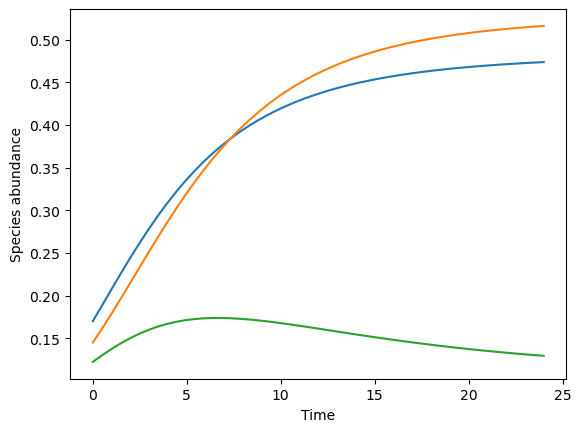

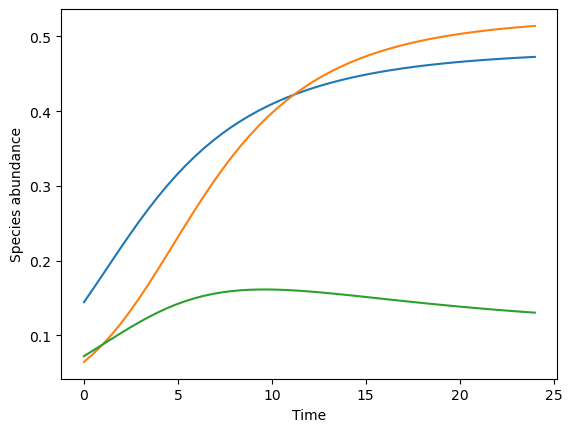

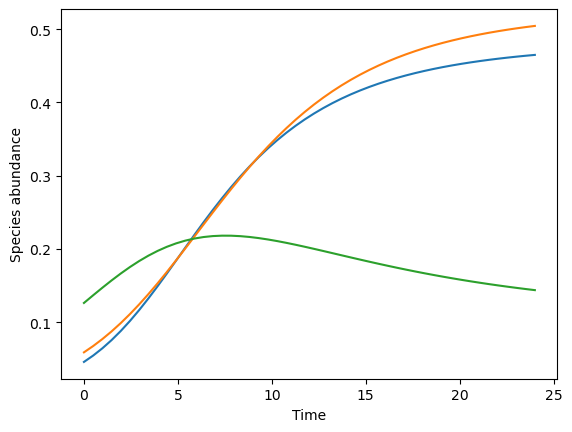

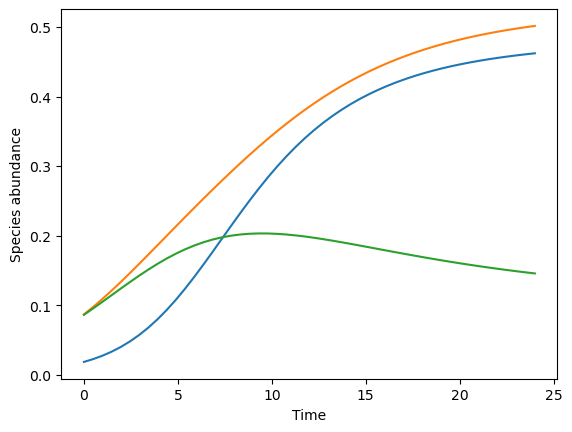

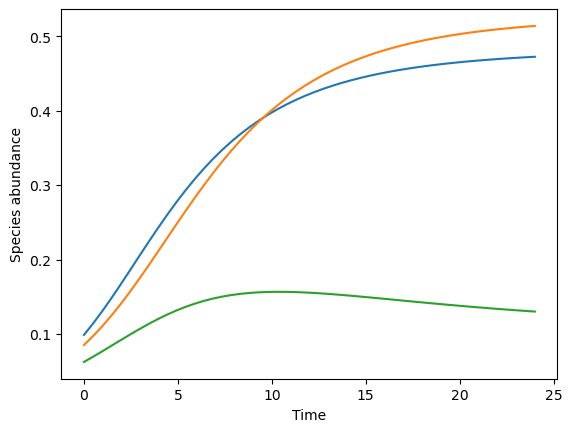

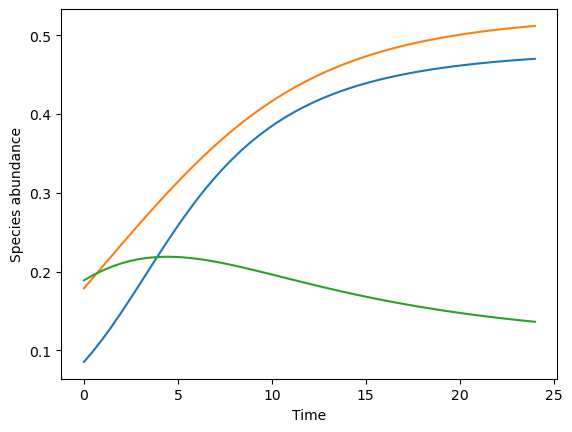

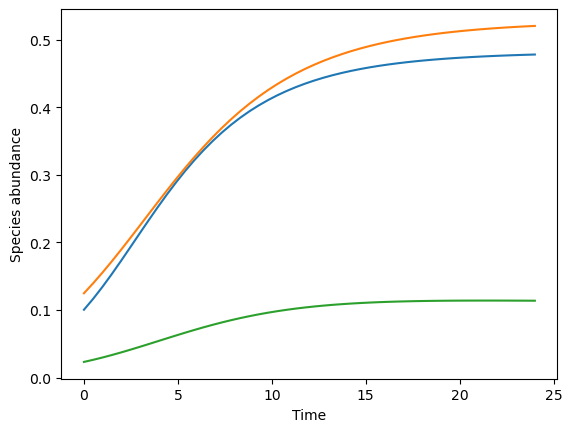

In [3]:
# plot data 
for x0 in x0s:
    
    # integrate ODE
    x = odeint(gLV_gt, x0, np.linspace(t_span[0], t_span[-1]), z_true)

    # plt each species
    for j in range(n_s):
        if x0[j] > 0:
            # plot data
            plt.plot(np.linspace(t_span[0], t_span[-1]), x[:,j], c=f'C{j}')
    # plt.legend(loc='lower right')
    plt.ylabel("Species abundance")
    plt.xlabel("Time")
    plt.show()

In [4]:
# generalized Lotka Volterra model (gLV)
@jit
def gLV(x, t, z):
    
    # modify output to make parameters make sense
    r, A = reshape_z(z)

    # make sure growth rates are positive
    r = jnp.exp2(r)/10.

    # make sure self interactions are negative
    for i in range(n_s):
        A = A.at[i,i].set(-jnp.exp2(A[i,i]))
    
    return x * (r + jnp.einsum('ij,j->i', A, x)) * (1. - x)

# define model that takes as input the initial condition the latent variables
@jit
def model(x, z):
    
    # integrate ODE
    t_hat = odeint(gLV, jnp.array(x[0]), t_span, z)
    
    # t_hat is the model estimate of observed variable t
    return t_hat[1:]

# gradient of model w.r.t. latent variables z
grad_model = jit(jacrev(model, 1))

# problem dimension
d = len(z_true)

# neural net dimension
h = 16

# determine shapes of weights/biases = [Wih, bih, Who, bho]
shapes = [[h, d], [h], [d, h], [d]]
k_params = []
n_params = 0
for shape in shapes:
    k_params.append(n_params)
    n_params += np.prod(shape)
k_params.append(n_params)

# initialize parameters
lmbda = np.zeros(n_params)
for k1,k2,shape in zip(k_params, k_params[1:], shapes):
    if len(shape)>1:
        stdv = 1./np.sqrt(shape[-1])
    lmbda[k1:k2] = stdv*np.random.randn(k2-k1,)
    
# reshape parameters into weight matrices and bias vectors
def reshape(params):
    # params is a vector = [Wih, bih, Who, bho]
    return [np.reshape(params[k1:k2], shape) for k1, k2, shape in
            zip(k_params, k_params[1:], shapes)]

@jit
def nn_int(y, t, lmbda):
    
    # weights and biases of nn
    W1, b1, W3, b3 = reshape(lmbda)
    
    # hidden layer
    h = tanh(jnp.einsum('ij,...j->...i', W1, y) + b1)
    # h = jnp.sin(jnp.einsum('ij,...j->...i', W1, jnp.append(y, t)) + b1)
    
    # hidden layer
    # h = tanh(jnp.einsum('ij,...j->...i', W2, h) + b2)
    
    # output
    dz_dt = jnp.einsum('ij,...j->...i', W3, h) + b3
    
    return dz_dt
jac_nn_int = jit(jacfwd(nn_int))

# neural network inside ode
@jit
def nn_int_log_pz(aug_y, t, lmbda):
    
    # unpack augmented y
    y, log_pz = aug_y
    
    # dz_dt 
    dz_dt = nn_int(y, t, lmbda)
    
    # log likelihood of z_t
    dlog_pz_dt = -jnp.trace(jac_nn_int(y, t, lmbda))
    
    return dz_dt, dlog_pz_dt

# neural ODE maps y -> z
@jit
def nn(y, lmbda):
    
    # integrate NN and log likelihood of z_t
    z = odeint(nn_int, y, jnp.array([0., 1.]), lmbda)

    return z[-1]
batch_nn = vmap(nn, (0, None))

# log likelihood of standard Gaussian
@jit 
def log_py(y):
    return -jnp.dot(y, y)/2. - len(y)/2 * jnp.log(2.*np.pi)

# neural ODE computes z and log p(z)
@jit
def nn_log_pz(y, lmbda):
    
    # initial condition for log_py
    log_py0 = log_py(y)
    
    # integrate NN and log likelihood of z_t
    z, log_pz = odeint(nn_int_log_pz, (y, log_py0), jnp.array([0., 1.]), lmbda)

    return z[-1], log_pz[-1]

@jit
def log_pz(y, lmbda):
    
    # initial condition for log_py
    log_py0 = log_py(y)
    
    # integrate NN and log likelihood of z_t
    z, log_pz = odeint(nn_int_log_pz, (y, log_py0), jnp.array([0., 1.]), lmbda)

    return log_pz[-1]
grad_log_pz = jit(jacrev(log_pz, 1))

# precision of Gaussian prior over z
alpha = .1

# set prior parameter mean on transformed variables
r_prior = np.log2(3.*np.ones(n_s))
A_prior = np.zeros([n_s, n_s])
for i in range(n_s):
    # self interaction
    A_prior[i, i] = np.log2(1.)
z_prior = jnp.append(r_prior, A_prior.flatten())

# evaluate log prior
@jit
def log_prior(y, lmbda):
    # map to sample from posterior
    z = nn(y, lmbda)
    
    # prior
    lp = alpha * jnp.sum((z-z_prior)**2) / 2.
    
    return lp

# eval log posterior in batches 
batch_log_prior = jit(vmap(log_prior, (0, None)))

# gradient of log posterior
grad_log_prior = jit(jacrev(log_prior, 1))

# gradient of log posterior
batch_grad_log_prior = jit(jacrev(batch_log_prior, 1))

# evaluate log likelihood 
@jit
def log_likelihood(y, x, lmbda):
    # map to sample from posterior
    z = nn(y, lmbda)
    
    # likelihood
    lp = beta * jnp.sum((x[1:] - model(x, z))**2) / 2. 
    
    return lp

# eval log posterior in batches 
batch_log_likelihood = jit(vmap(log_likelihood, (0, None, None)))

# gradient of log posterior w.r.t. variational parameters lmbda
grad_log_likelihood = jit(jacrev(log_likelihood, 2))

# batch evaluation of gradient of log posterior
batch_grad_log_likelihood = jit(jacrev(batch_log_likelihood, 2))

print(f"number of parameters in nn: {n_params}")

number of parameters in nn: 412


In [5]:
# ELBO cost function 
def elbo(lmbda, n_sample=10):
    
    # use nn to sample parameters
    y = np.random.randn(n_sample, d)
    
    # evaluate model fitness 
    '''ELBO = np.nanmean(batch_log_prior(y, lmbda), 0)
    for x in X:
        ELBO += np.nanmean(batch_log_likelihood(y, x, lmbda), 0)
    ELBO -= np.nanmean(batch_log_det(y, lmbda), 0)'''
    
    ELBO = 0.
    for yi in y:
        
        # entropy
        ELBO += np.nan_to_num(log_pz(yi, lmbda)) / n_sample
        
        # prior
        ELBO += np.nan_to_num(log_prior(yi, lmbda)) / n_sample
        
        # likelihood
        for x in X:
            ELBO += np.nan_to_num(log_likelihood(yi, x, lmbda)) / n_sample
    
    return ELBO

# gradient of ELBO cost function
def grad_elbo(lmbda, x, n, n_sample=10):
    
    # use nn to sample parameters
    y = np.random.randn(n_sample, d)
    
    # gradient 
    '''grad_ELBO = np.nanmean(batch_grad_log_prior(y, lmbda), 0)
    for x in X:
        grad_ELBO += np.nanmean(batch_grad_log_likelihood(y, x, lmbda), 0)
    grad_ELBO -= np.nanmean(batch_grad_log_det(y, lmbda), 0)'''
    
    grad_ELBO = 0.
    for yi in y:
            
        # entropy
        grad_ELBO += np.nan_to_num(grad_log_pz(yi, lmbda)) / n / n_sample
        
        # prior 
        grad_ELBO += np.nan_to_num(grad_log_prior(yi, lmbda)) / n / n_sample
        
        # likelihood
        grad_ELBO += np.nan_to_num(grad_log_likelihood(yi, x, lmbda)) / n_sample
    
    return grad_ELBO

In [6]:
def lin_fit(x, a, b):
    return a + b * x

def check_convergence(f):
    p, cov = curve_fit(lin_fit, xdata=np.arange(len(f)), ydata=f/np.max(f), p0=[1., 0.])
    a, b, = p

    # return value of slope
    return b

# adam from chat gpt
def adam_optimizer(f, grad_f, params, 
                   learning_rate=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8, 
                   max_iterations=10000, tol=1e-3, patience=3):
    """
    ADAM optimizer for minimizing a function.

    Parameters:
    - grad_f: Gradient function that returns the gradient of the objective function.
    - initial_params: Initial guess for the parameters.
    - learning_rate: Step size for the optimization (default: 0.001).
    - beta1: Exponential decay rate for the first moment estimate (default: 0.9).
    - beta2: Exponential decay rate for the second moment estimate (default: 0.999).
    - epsilon: Small constant to prevent division by zero (default: 1e-8).
    - max_iterations: Maximum number of iterations (default: 1000).
    - tol: Tolerance to stop optimization when the change in parameters is below this value (default: 1e-6).

    Returns:
    - Optimal parameters.
    """
    m = np.zeros_like(params)
    v = np.zeros_like(params)
    t = 0
    f = []
    best_params = np.copy(params)
    
    while len(f) < max_iterations:
        
        # evaluate ELBO
        f.append(elbo(params))
        
        # check convergence given enough evaluations 
        if len(f) > 10:
            
            # save parameters if they're improving
            if f[-1] < np.mean(f[-10:]):
                print("Saved parameters")
                best_params = np.copy(params)
            
            # if function eval was a standard deviation greater than mean,
            # reset to saved parameters and lower the learning rate! 
            if f[-1] > np.mean(f[-10:]) + np.std(f[-10:]): 
                print("Reset parameters")
                params = np.copy(best_params)
                learning_rate *= .5
            else:

                # determine slope of elbo over time
                slope = check_convergence(f[-10:])

                # if performance is not improving, decrease lr
                if slope > 0:
                    learning_rate *= .9 
                    print("decrease lr to {:.3e}".format(learning_rate))

                # try to accelerate  
                if slope < -1e-2:
                    learning_rate = np.min([1.1*learning_rate, .01])
                    print("set lr to {:.3e}".format(learning_rate))

                # convergence criteria 
                if learning_rate < 1e-5: 
                    return best_params, f
            
            print("ELBO: {:.3f}, Slope: {:.3f}".format(f[-1], slope))
        else:
            print("ELBO: {:.3f}".format(f[-1]))

        # sgd 
        order = np.arange(len(X))
        np.random.shuffle(order)
        for x in X[order]:
        
            gradient = grad_f(params, x, len(X)) 

            m = beta1 * m + (1 - beta1) * gradient
            v = beta2 * v + (1 - beta2) * (gradient ** 2)

            t += 1
            m_hat = m / (1 - beta1 ** t)
            v_hat = v / (1 - beta2 ** t)

            params -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

    return best_params, f

In [15]:
# optimize nn parameters
lmbda, f = adam_optimizer(elbo, grad_elbo, lmbda, learning_rate=1e-2)

ELBO: 2859.711
ELBO: 2154.457
ELBO: 2113.142
ELBO: 2247.576
ELBO: 1336.157
ELBO: 1018.430
ELBO: 986.479
ELBO: 876.063
ELBO: 1003.200
ELBO: 725.329
Saved parameters
set lr to 1.000e-02
ELBO: 524.526, Slope: -0.086
Saved parameters
set lr to 1.000e-02
ELBO: 592.236, Slope: -0.078
Saved parameters
set lr to 1.000e-02
ELBO: 401.384, Slope: -0.067
Saved parameters
set lr to 1.000e-02
ELBO: 811.269, Slope: -0.056
Saved parameters
set lr to 1.000e-02
ELBO: 328.572, Slope: -0.067
Saved parameters
set lr to 1.000e-02
ELBO: 349.635, Slope: -0.069
Saved parameters
set lr to 1.000e-02
ELBO: 400.575, Slope: -0.061
Saved parameters
set lr to 1.000e-02
ELBO: 409.430, Slope: -0.054
Saved parameters
set lr to 1.000e-02
ELBO: 243.042, Slope: -0.050
set lr to 1.000e-02
ELBO: 521.191, Slope: -0.027
Saved parameters
set lr to 1.000e-02
ELBO: 264.410, Slope: -0.035
Saved parameters
set lr to 1.000e-02
ELBO: 209.401, Slope: -0.037
Saved parameters
set lr to 1.000e-02
ELBO: 239.027, Slope: -0.046
Reset parame

In [16]:
# sample noise
# y = np.random.random(size=[1000, d])
y = np.random.randn(500, d)
z = batch_nn(y, lmbda)

In [17]:
# transform to correct z vale
def z_transform(z):
    # modify output to make parameters make sense
    r, A = reshape_z(z)

    # make sure growth rates are positive
    r = jnp.exp2(r)/10.

    # make sure self interactions are negative
    for i in range(n_s):
        A = A.at[i,i].set(-jnp.exp2(A[i,i]))
        
    return jnp.append(r, A.flatten())

batch_z_transform = jit(vmap(z_transform))
z = batch_z_transform(z)

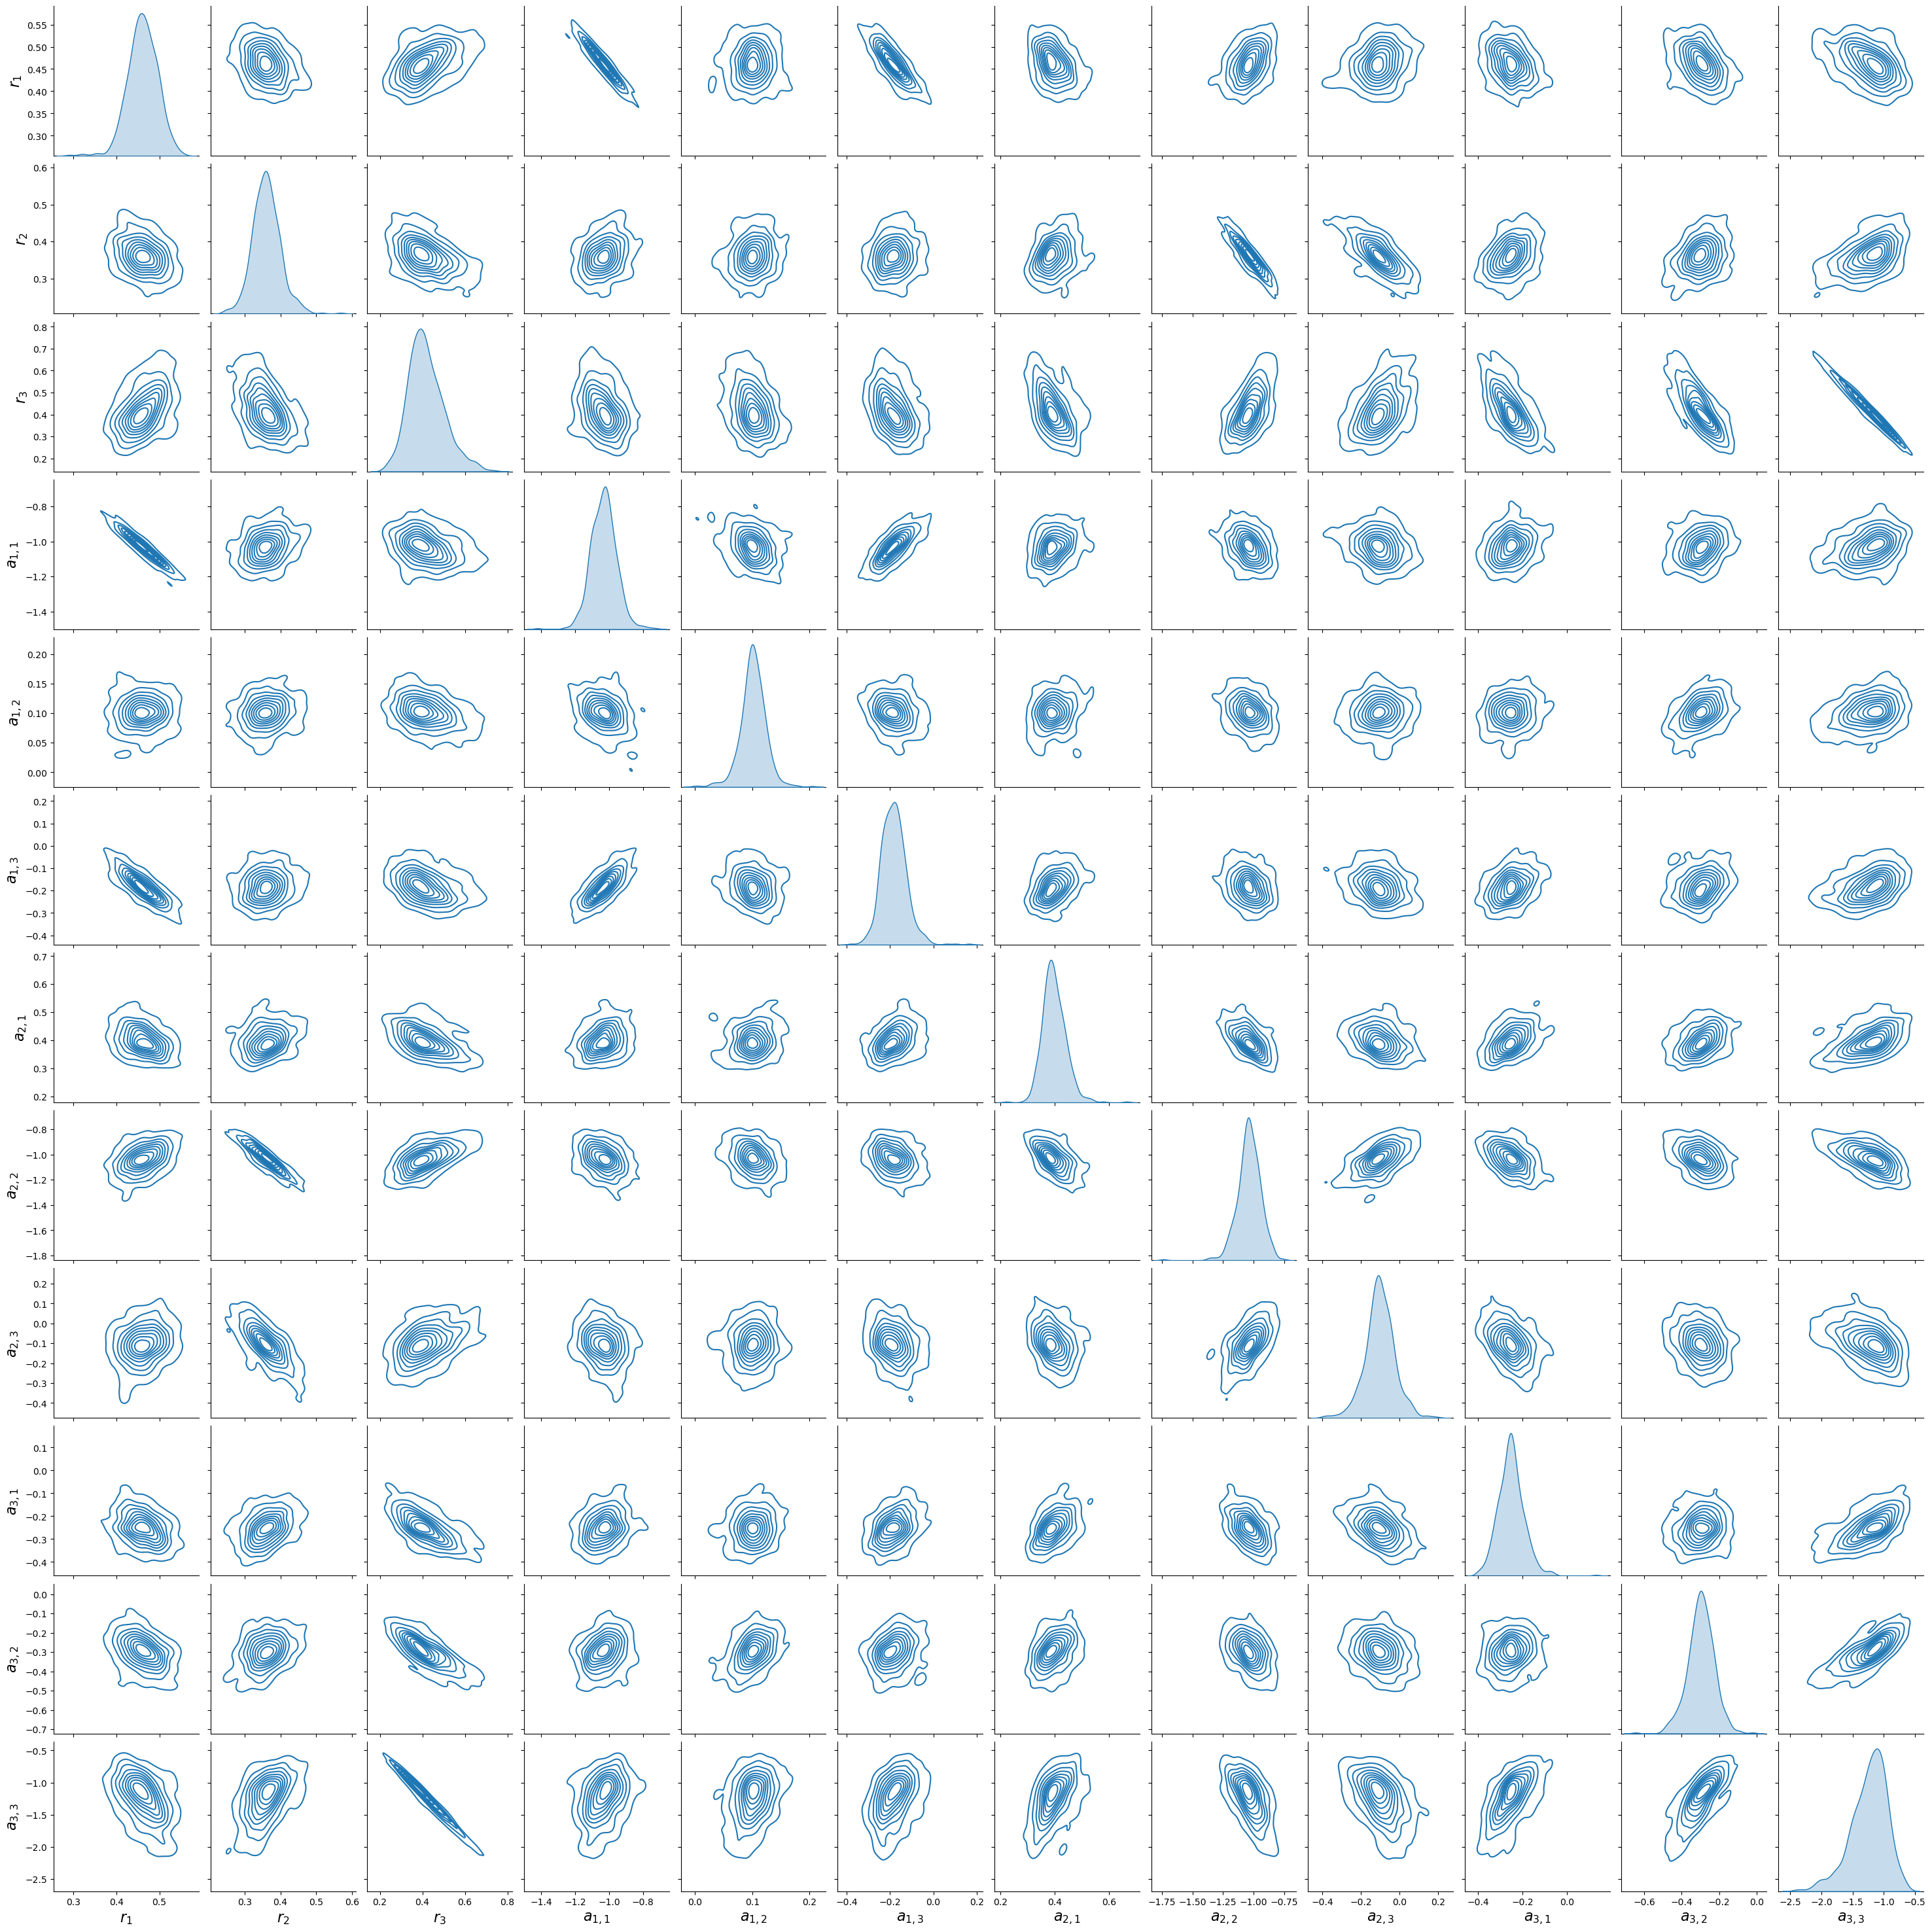

In [18]:
param_names = [f'$r_{i+1}$' for i in range(n_s)]
for i in range(n_s):
    for j in range(n_s):
        param_names += ['$a_{'+str(i+1)+","+str(j+1)+'}$']

z_df = pd.DataFrame()
z_df[param_names] = np.array(z, float)

g = sns.pairplot(z_df, kind="kde")

# Increase the font size of x and y axis labels for each subplot
for ax in g.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)

plt.show()

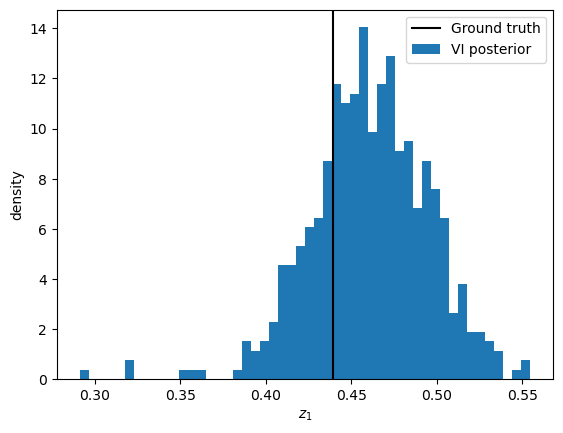

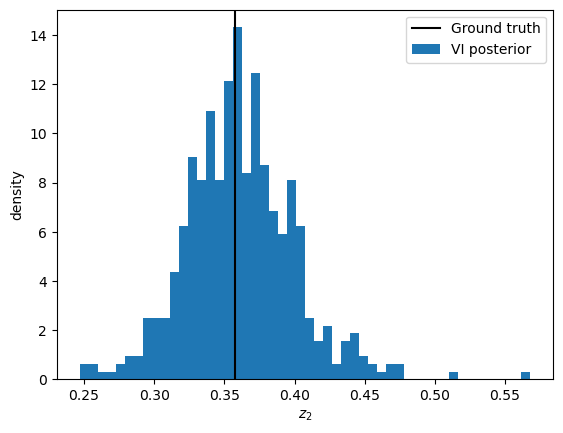

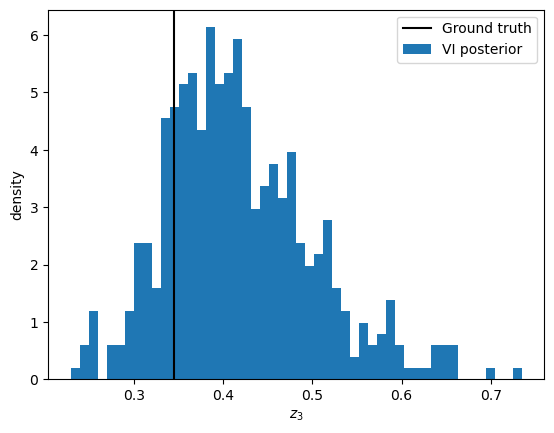

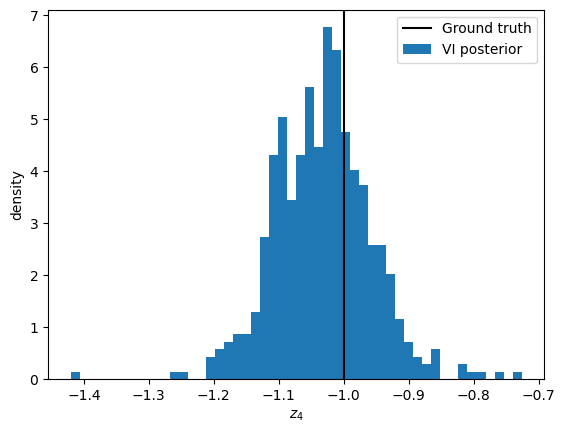

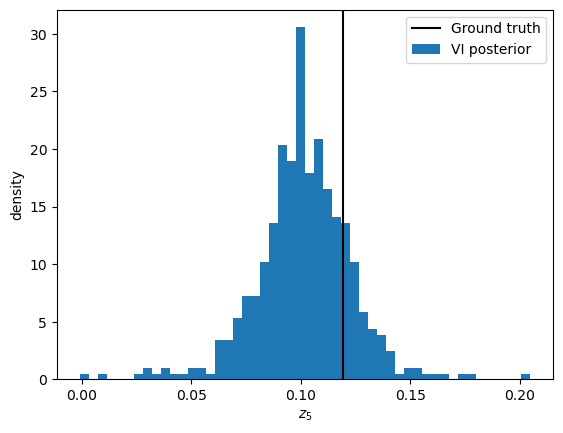

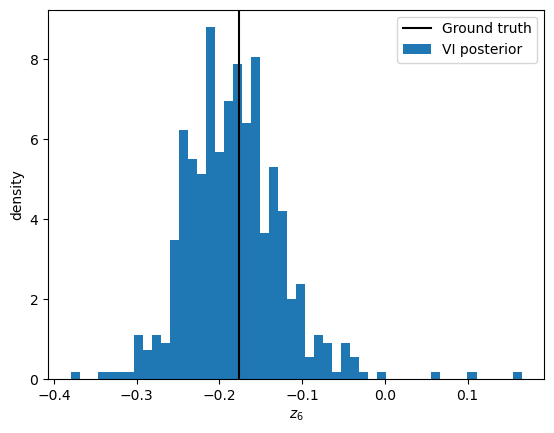

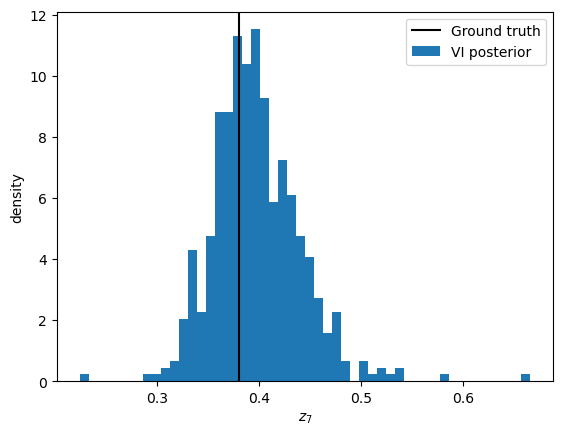

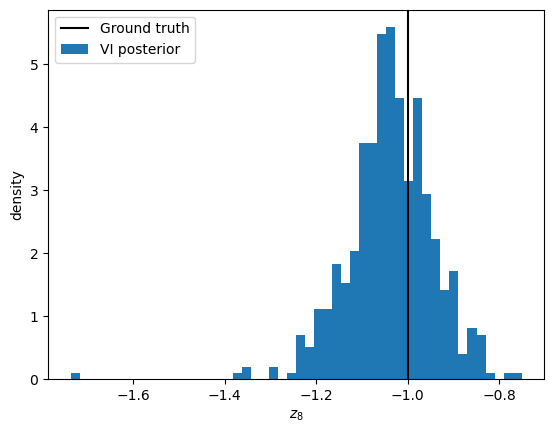

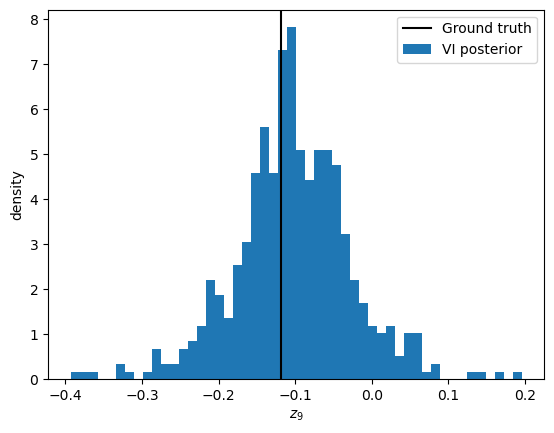

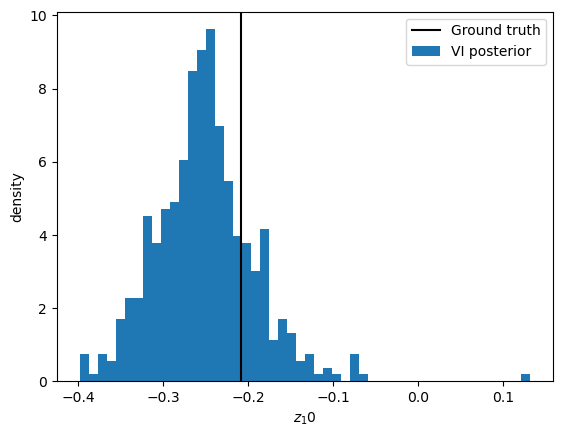

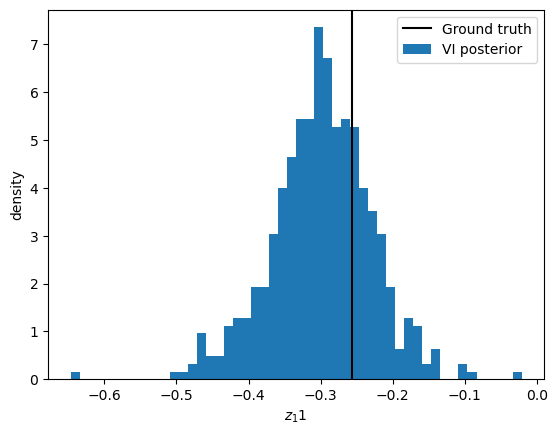

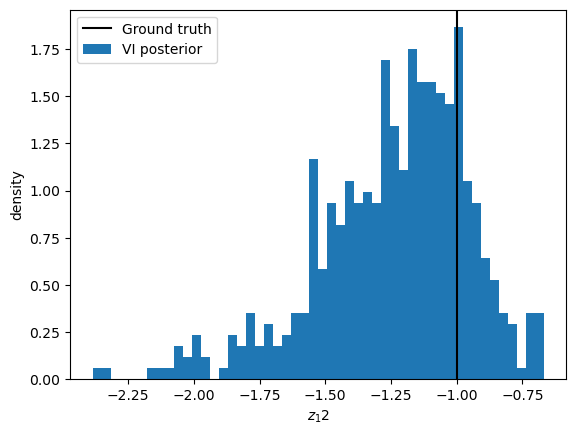

In [19]:
for i, z_true_i in enumerate(z_true):
    
    # plot NN posterior 
    plt.hist(np.array(z[:, i]), color='C0', bins=50, density=True, label='VI posterior')
    plt.axvline(x=z_true_i, c='k', label='Ground truth')
    
    plt.xlabel(f"$z_{i+1}$")
    plt.ylabel("density")
    plt.legend()
    plt.show()

In [20]:
# integrate gLV and add noise to generate simulated data
Xplt = []
for x0 in x0s:
    # integrate ODE
    x = odeint(gLV_gt, jnp.array(x0), t_span, z_true)
    
    # add noise after initial condition of inoculated species
    x = x.at[1:].set(x[1:] + s*np.random.randn(m-1, n_s))
    x = jnp.einsum('tk,k->tk', x, np.array(x[0]>0, int))

    # append to X
    Xplt.append(x)
    
# stack X as an array 
Xplt = np.stack(Xplt)

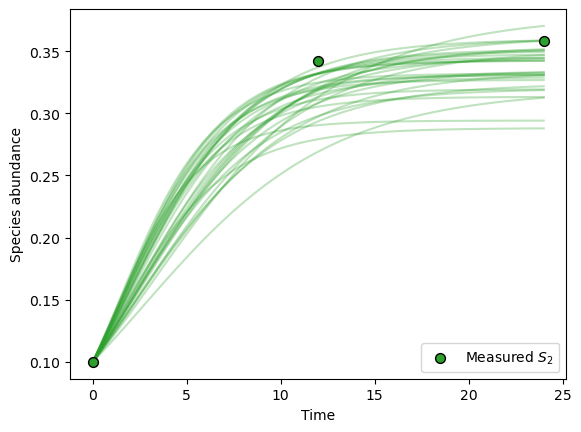

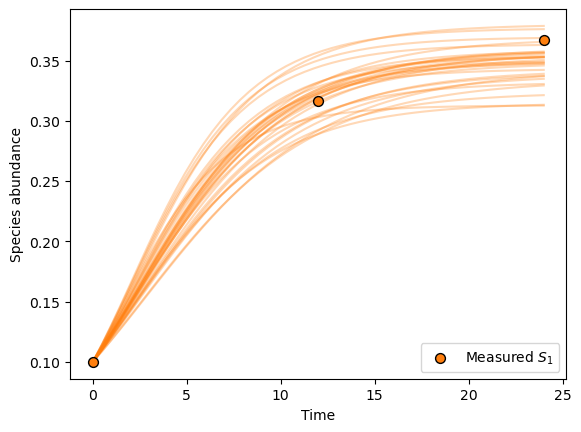

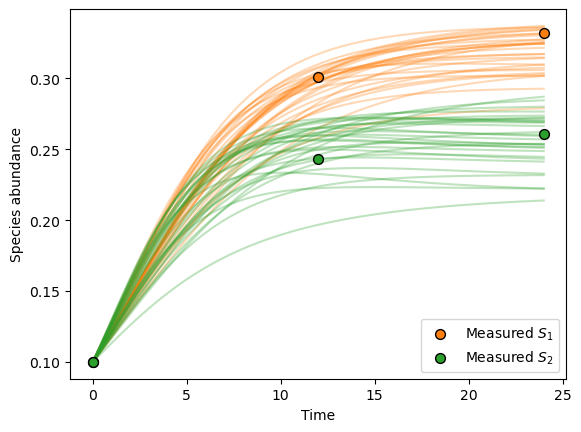

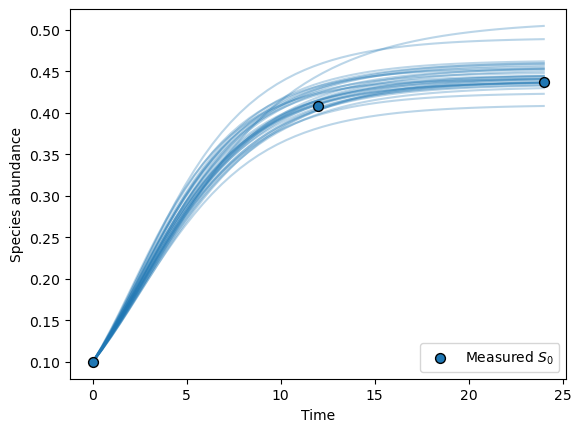

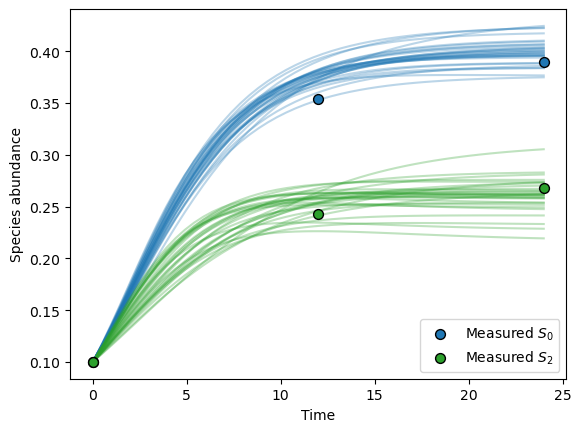

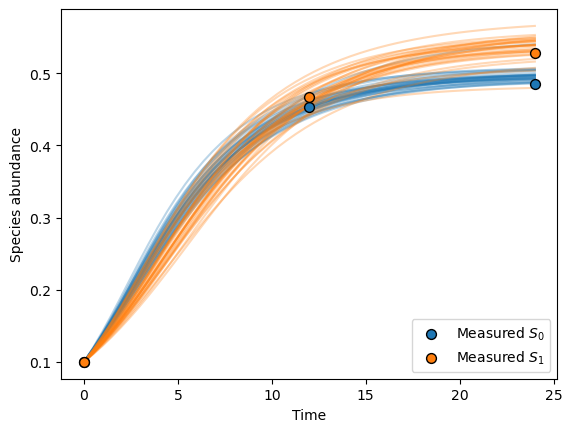

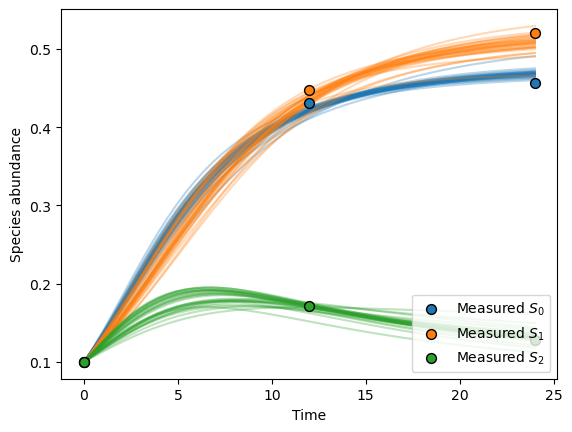

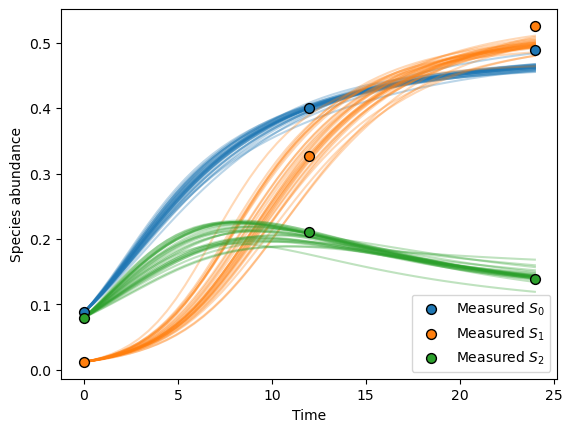

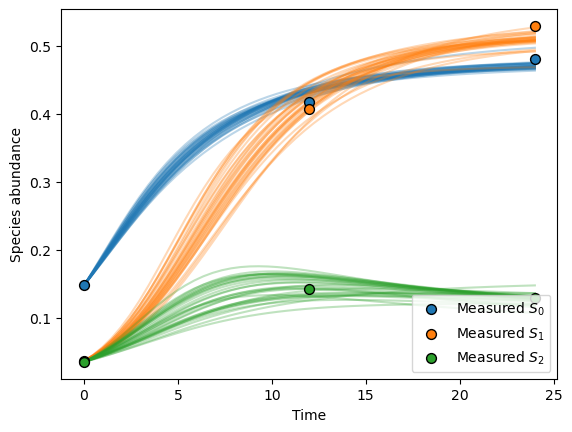

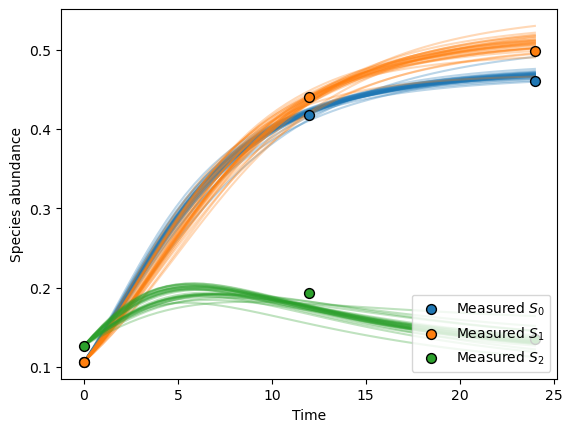

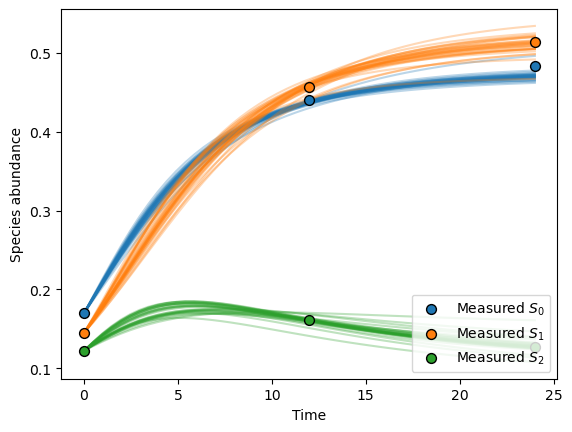

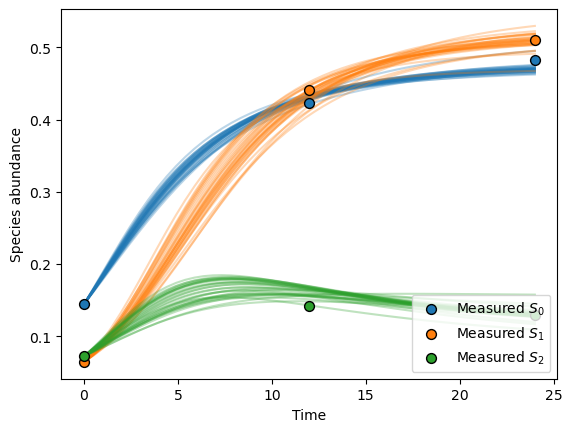

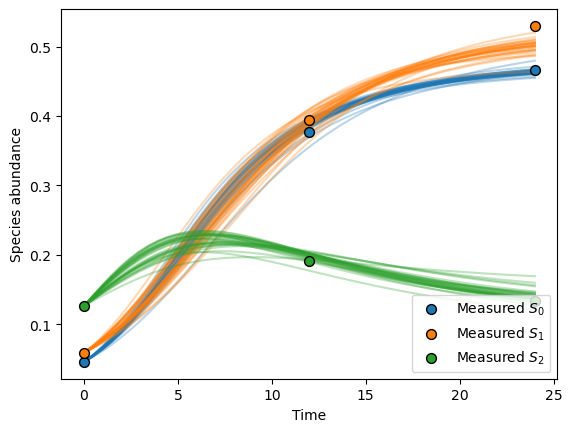

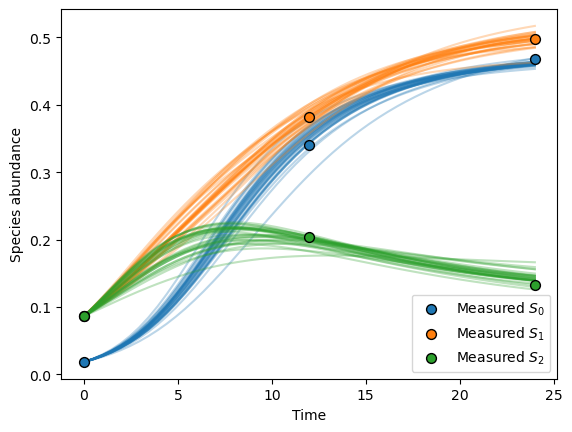

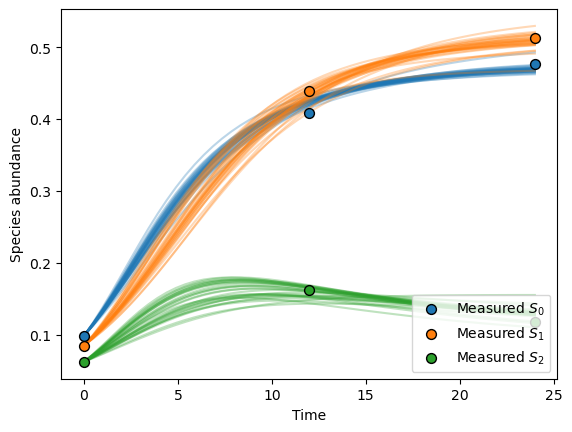

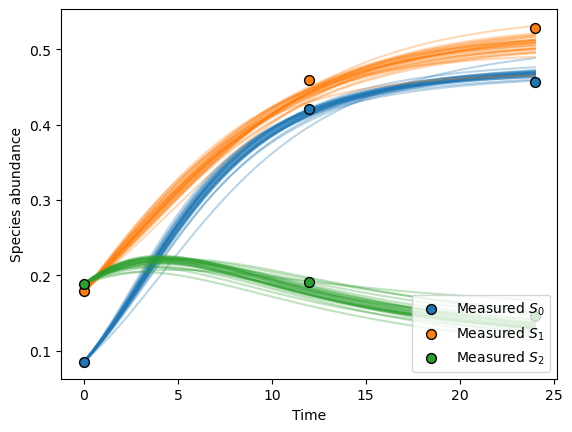

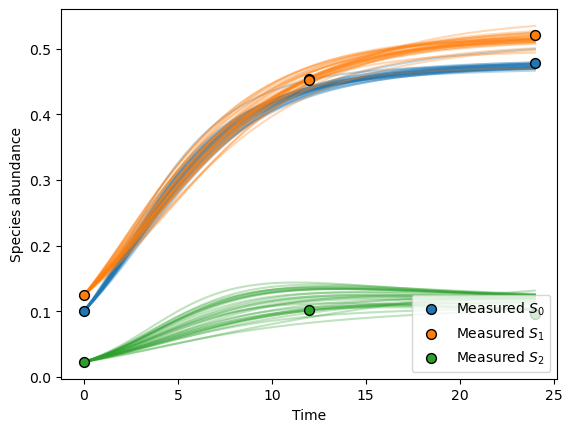

In [21]:
# sample noise
# y = np.random.random(size=[1000, d])
y = np.random.randn(30, d)
z = batch_nn(y, lmbda)

# plot data 
for Xi in Xplt:

    # plt each species
    for j in range(n_s):
        if Xi[0,j] > 0:
            # plot data
            plt.scatter(t_span, Xi[:,j], c=f'C{j}', label=f"Measured $S_{j}$",
                        zorder=1, edgecolor='k', s=50)
            
            # plot samples from posterior
            for z_sample in z:
                x = odeint(gLV, Xi[0], np.linspace(t_span[0], t_span[-1]), z_sample)
                plt.plot(np.linspace(t_span[0], t_span[-1]), x[:,j], c=f'C{j}', alpha=.3, zorder=0)
    plt.legend(loc='lower right')
    plt.ylabel("Species abundance")
    plt.xlabel("Time")
    plt.show()

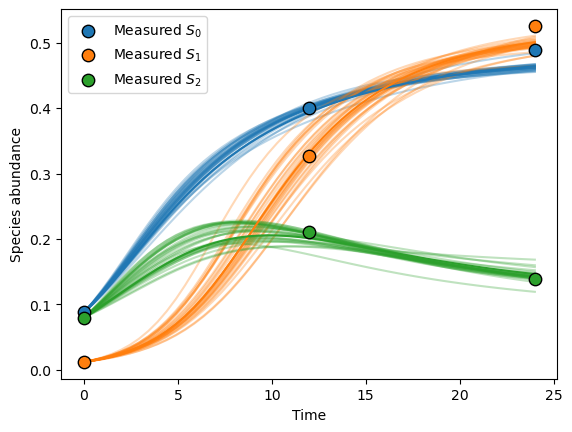

In [24]:
# pick condition
i = -10

# plt each species
for j in range(n_s):
    if Xplt[i][0,j] > 0:
        # plot data
        plt.scatter(t_span, Xplt[i][:,j], c=f'C{j}', label=f"Measured $S_{j}$",
                    zorder=2, edgecolor='k', s=80)

        # ground truth
        x = odeint(gLV_gt, Xplt[i][0], np.linspace(t_span[0], t_span[-1]), z_true)
        plt.plot(np.linspace(t_span[0], t_span[-1]), x[:,j], c=f'C{j}', alpha=1., zorder=1)
        
        # plot samples from posterior
        for z_sample in z:
            x = odeint(gLV, Xplt[i][0], np.linspace(t_span[0], t_span[-1]), z_sample)
            plt.plot(np.linspace(t_span[0], t_span[-1]), x[:,j], c=f'C{j}', alpha=.3, zorder=0)
plt.legend(loc='upper left')
plt.ylabel("Species abundance")
plt.xlabel("Time")
plt.savefig("figures/gLV_example.png")
plt.show()